**CSCI 4831: Sabermetrics Final Project**  
Name: Adam Ten Hoeve

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Read in all of the statcast data
# df2016 = pd.read_csv("2016/data2016.csv")

# april2017 = pd.read_csv("2017/dataApril2017.csv")
# may2017 = pd.read_csv("2017/dataMay2017.csv")
# june2017 = pd.read_csv("2017/dataJune2017.csv")
# july2017 = pd.read_csv("2017/dataJuly2017.csv")
# aug2017 = pd.read_csv("2017/dataAug2017.csv")
# sept2017 = pd.read_csv("2017/dataSept2017.csv")
# oct2017 = pd.read_csv("2017/dataOct2017.csv")

april2018 = pd.read_csv("2018/dataApril2018.csv")
may2018 = pd.read_csv("2018/dataMay2018.csv")
june2018 = pd.read_csv("2018/dataJune2018.csv")
july2018 = pd.read_csv("2018/dataJuly2018.csv")
aug2018 = pd.read_csv("2018/dataAug2018.csv")
sept2018 = pd.read_csv("2018/dataSept2018.csv")
oct2018 = pd.read_csv("2018/dataOct2018.csv")

# df2017 = pd.concat([april2017, may2017, june2017, july2017, aug2017, sept2017, oct2017])
df2018 = pd.concat([april2018, may2018, june2018, july2018, aug2018, sept2018, oct2018])

# dfTotal = pd.concat([df2016, df2017, df2018])
dfTotal = df2018.copy()

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [30]:
# Clean the data. 
# Group by pitcher. Get rid of anyone who pitched less than 100 times in the three years.
dfTempPitch = dfTotal.groupby("player_name", as_index = False).count()
dfTempPitch = dfTempPitch.loc[dfTempPitch["index"] > 100]
# Then group by batter to get rid of any batters who batted less than 100 times.
dfTempBat = dfTotal.groupby("batter", as_index = False).count()
dfTempBat = dfTempBat.loc[dfTempBat["index"] > 100]

# Create a database of pitchers 
dfPitchers = pd.merge(dfTotal, dfTempPitch[["player_name"]], on = "player_name", how = "inner")
# Create a database of batters
dfBatters = pd.merge(dfTotal, dfTempBat[["batter"]], on = "batter", how = "inner")

# Create a final dataframe of the cleaned batter and pitcher data
dfFinal = pd.merge(dfPitchers, dfBatters[["index", "pitcher", "batter", "release_speed", "strikes", "balls"]], on = ["index", "pitcher", "batter", "release_speed", "strikes", "balls"], how = "inner")

In [31]:
# A list of events of the batter either striking out or hitting the ball into play.
events = ["strikeout", "strikeout_double_play", "single", "double", "triple", "home_run", "sac_bunt", "sac_fly", "field_out", "field_error", "double_play", "grounded_into_double_play", "sac_fly_double_play", "triple_play", "walk", "hit_by_pitch"]
# Get rid of all the rows of data that don't have one of the events listed.
Outcomes = dfFinal.loc[dfFinal["events"].isin(events)]

In [32]:
# Calculate the proportion of each type of event. Will be used to calculate the weight of certain outcomes.
OutcomesProp = Outcomes.groupby("events", as_index = False).count()
numEvents = len(Outcomes)
OutcomesProp["proportion"] = OutcomesProp["index"] / numEvents
OutcomesProp = OutcomesProp[["events", "index", "proportion"]]
OutcomesProp

,events,index,proportion
0,double,7989,0.045871
1,double_play,444,0.002549
2,field_error,1517,0.008710
3,field_out,71342,0.409628
4,grounded_into_double_play,3330,0.019120
5,hit_by_pitch,1857,0.010662
6,home_run,5418,0.031109
7,sac_bunt,718,0.004123
8,sac_fly,1186,0.006810
9,sac_fly_double_play,10,0.000057


In [33]:
# Create a dictionary of all batters and pitchers
batterElos = {}
pitcherElos = {}

# ids = list(Outcomes["pitcher"].unique()) + list(Outcomes["batter"].unique())
for id in list(Outcomes["pitcher"].unique()):
    pitcherElos[id] = 1000
for id in list(Outcomes["batter"].unique()):
    batterElos[id] = 1000
    
# Create a list of pitcher-favored outcomes.
pitcherFavored = ["strikeout", "strikeout_double_play", "field_out", "double_play", "grounded_into_double_play", "sac_fly_double_play", "triple_play"]
# Create a list of batter favored outcomes, meaning they did not get out by the end of the play.
batterFavored = ["single", "double", "triple", "home_run", "field_error", "walk", "hit_by_pitch", "sac_bunt", "sac_fly"]

In [34]:
# Create a dictionary of actual historical result data. This will be to compare the predicted outcome probabilities
histResults = {}
for pid in list(Outcomes["pitcher"].unique()):
        for bid in list(Outcomes["batter"].unique()):
            histResults[(pid, bid)] = np.array([0,0])

In [35]:
def PercentOnBase(row):
    if row["events"] in batterFavored:
        return 1
    return 0

# Find how often batters get on base
total = len(Outcomes)
probBatterWins = np.sum(Outcomes.apply(PercentOnBase, axis = 1)) / total
probPitchWins = 1 - probBatterWins

print(probBatterWins, probPitchWins)

0.34086459236462396 0.659135407635376


In [36]:
# Batters only "win" about 35% of the time. So weight the eventual scores so it's as if they win 50% of the time.
# Way better than the old system of weighting scores individually
batterWeight = 0.5 / probBatterWins
pitcherWeight = 0.5 / (1 - probBatterWins)

print(batterWeight, pitcherWeight)

1.466858134285618 0.7585694748120596


In [37]:
# Determines the weight on the elo based on the type of event.
# Used to balance the proportion of pitcher-wins to batter-wins.
# Otherwise pitchers win about 70% of the time and dominate the scores
def EloEventWeight(event):
    # If that event occured
    if event == "strikeout":
        # Return the prob of that event times the assigned weight based on impact
        # All weights have are *2 what they normally are to speed up processing by preventing floating point arithmetic.
        return OutcomesProp.loc[OutcomesProp["events"] == "strikeout"]["proportion"] * 2
    elif event == "field_out":
        return OutcomesProp.loc[OutcomesProp["events"] == "field_out"]["proportion"] * 1
    elif event == "double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "double_play"]["proportion"] * 4
    elif event == "grounded_into_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "grounded_into_double_play"]["proportion"] * 4
    elif event == "strikeout_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "strikeout_double_play"]["proportion"] * 4
    elif event == "triple_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "triple_play"]["proportion"] * 6
    elif event == "sac_fly_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_fly_double_play"]["proportion"] * 2
    elif event == "single":
        return OutcomesProp.loc[OutcomesProp["events"] == "single"]["proportion"] * 2
    elif event == "double":
        return OutcomesProp.loc[OutcomesProp["events"] == "double"]["proportion"] * 4
    elif event == "triple":
        return OutcomesProp.loc[OutcomesProp["events"] == "triple"]["proportion"] * 6
    elif event == "home_run":
        return OutcomesProp.loc[OutcomesProp["events"] == "home_run"]["proportion"] * 8
    elif event == "sac_bunt":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_bunt"]["proportion"] * 2
    elif event == "sac_fly":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_fly"]["proportion"] * 2
    elif event == "field_error":
        return OutcomesProp.loc[OutcomesProp["events"] == "field_error"]["proportion"] * 2
    elif event == "walk":
        return OutcomesProp.loc[OutcomesProp["events"] == "walk"]["proportion"] * 2
    elif event == "hit_by_pitch":
        return OutcomesProp.loc[OutcomesProp["events"] == "hit_by_pitch"]["proportion"] * 2
    else:
        # something got through that wasn't supposed to get through
        print(event)
        return 0.5

In [38]:
# Create a function to calculate the probability a pitcher wins the matchup
def ProbPitcherWins(pitcher, batter):
    # Get ranking of pitcher and batter
    pitcherRank = pitcherElos[pitcher]
    batterRank = batterElos[batter]
    # From elo rankings. Assumes a difference of 400 is the same as 1 player being 10 times as likely to win
    probPitcherWins = 1 / (1 + 10**((batterRank - pitcherRank)/1000))
    return probPitcherWins

In [39]:
# Create a function to update the scores of players based on the results of pitches
def UpdateElo(row):
    p = row["pitcher"]
    b = row["batter"]
    # Get the probability that the pitcher wins from the function above
    prob = ProbPitcherWins(p, b)
    # Update the ratings based on the outcome of the pitch
    # If pitcher "wins" the matchup
    if row["events"] in pitcherFavored:
        # Largest possible change in score is 32.
        # Shown 16 here because *2 in weight function to prevent float multiplication.
        pitcherElos[p] = np.floor(pitcherElos[p] + (32 * pitcherWeight * (1 - prob)))
        batterElos[b] = np.floor(batterElos[b] + (32 * pitcherWeight * (prob - 1)))
        histResults[(p, b)] = histResults[(p, b)] + np.array([1, 0])
    # If the batter wins the matchup
    else:
        pitcherElos[p] = np.floor(pitcherElos[p] + (32 * batterWeight * (prob - 1)))
        batterElos[b] = np.floor(batterElos[b] + (32 * batterWeight * (1 - prob)))
        histResults[(p, b)] = histResults[(p, b)] + np.array([0, 1])

In [40]:
Outcomes.apply(UpdateElo, axis = 1);

In [41]:
print(max(list(batterElos.values())))

4770.0


In [42]:
print(list(batterElos.values()))

[2040.0, 730.0, 1086.0, 461.0, 1160.0, 470.0, 1045.0, 2916.0, 1114.0, 617.0, 1417.0, 447.0, 445.0, 457.0, 379.0, 3943.0, 1001.0, 2913.0, 581.0, 888.0, 1320.0, 669.0, 541.0, 292.0, 2974.0, 619.0, 1411.0, -65.0, 801.0, 591.0, 968.0, 998.0, 646.0, 971.0, 721.0, 446.0, 805.0, 281.0, 440.0, 1883.0, 1767.0, 687.0, 1087.0, 2272.0, 861.0, 1003.0, 954.0, 1236.0, 583.0, 1841.0, 1350.0, 1512.0, 704.0, 1266.0, 733.0, 1491.0, 715.0, 1319.0, 328.0, 4770.0, 819.0, 105.0, 1413.0, 2386.0, 325.0, 740.0, 1197.0, 223.0, 1086.0, 923.0, 1511.0, 975.0, 265.0, 1550.0, 2318.0, 610.0, 904.0, 1133.0, 449.0, 1051.0, 917.0, 305.0, 1013.0, 1084.0, 906.0, 666.0, 133.0, 1224.0, 1272.0, 1128.0, 675.0, 195.0, 47.0, 698.0, 882.0, 2245.0, 4598.0, 729.0, 672.0, 945.0, 885.0, 564.0, 362.0, 952.0, 2113.0, 1083.0, 799.0, 1081.0, 402.0, 1217.0, 439.0, 1394.0, 623.0, 807.0, 771.0, 752.0, 584.0, 848.0, 11.0, 929.0, 422.0, 587.0, 1204.0, 1189.0, 3852.0, 2584.0, 1639.0, 1282.0, 395.0, 883.0, 1022.0, 1133.0, 439.0, 858.0, 1230.0, 

In [43]:
print(max(list(pitcherElos.values())))

1866.0


In [44]:
print(list(pitcherElos.values()))

[1120.0, 939.0, 1200.0, 1161.0, 480.0, 549.0, 1023.0, -17.0, -524.0, 831.0, 825.0, 1413.0, 995.0, 1055.0, 651.0, 203.0, 1451.0, 1345.0, 609.0, 1244.0, 1131.0, 292.0, 942.0, 569.0, 717.0, 956.0, 1141.0, 786.0, 1300.0, 812.0, 847.0, 1367.0, 1259.0, 1064.0, -561.0, 391.0, 629.0, 1098.0, 666.0, 1259.0, 239.0, 1291.0, 972.0, 655.0, 548.0, 920.0, 804.0, 1168.0, 841.0, 729.0, 307.0, 932.0, 1142.0, 1233.0, 1037.0, 1114.0, 1072.0, 1357.0, -230.0, 1600.0, 1330.0, 1299.0, 1202.0, -382.0, 921.0, 525.0, 472.0, 1178.0, 527.0, 860.0, 1246.0, 1235.0, 757.0, 1033.0, 1117.0, 1160.0, 654.0, 1451.0, 1231.0, 730.0, 1018.0, 1116.0, 374.0, 837.0, -584.0, 1202.0, 1213.0, 66.0, 1260.0, 1290.0, 893.0, 931.0, 808.0, -316.0, 894.0, 463.0, 1141.0, 1193.0, -1161.0, 1251.0, 1085.0, 1112.0, 1107.0, 304.0, 899.0, 899.0, 1137.0, 706.0, 690.0, 902.0, 681.0, 738.0, -216.0, 1553.0, 664.0, 640.0, 857.0, 830.0, 935.0, 692.0, 642.0, 1283.0, 942.0, 1016.0, 1387.0, 896.0, 1136.0, 1491.0, 1190.0, 640.0, 1270.0, 1155.0, 386.0, 7

In [45]:
# Create dictionaries to convert player names and ids
IDtoName = {}
NametoID = {}
# Get all the unique players
temp = Outcomes[["player_name", "pitcher"]].groupby(by = "pitcher", as_index = False).first()

for i in range(len(temp)):
    IDtoName[temp["pitcher"].iloc[i]] = temp["player_name"].iloc[i]
    NametoID[temp["player_name"].iloc[i]] = temp["pitcher"].iloc[i]

In [46]:
# Create a dictionary to convert the player ID's to names
def PlayerIDtoName(id):
    return(IDtoName[id])

# Create a function to convert player's name to ID
def PlayerNametoID(name):
    return(NametoID[name])

In [47]:
def PredictWinner(pitcherID, batterID):
    # Get the elos of both players
    probPWins = ProbPitcherWins(pitcherID, batterID)
    print("Batter Elo:", batterElos[batterID])
    print("Pitcher Elo:", pitcherElos[pitcherID])
    print("The probability that the pitcher wins is", probPWins)
    
    # Find the actual historical data on who won the at-bat
    histData = histResults[(pitcherID, batterID)]
    percentPWon = histData[0] / np.sum(histData)
    print("The percentage of at-bat appearances the pitcher won is", percentPWon)

In [48]:
PredictWinner(433587.0, 134181.0)
PredictWinner(592811.0, 134181.0)
PredictWinner(543037.0, 134181.0)

Batter Elo: 998.0
Pitcher Elo: 40.0
The probability that the pitcher wins is 0.09922401559166462
The percentage of at-bat appearances the pitcher won is 0.5714285714285714
Batter Elo: 998.0
Pitcher Elo: 962.0
The probability that the pitcher wins is 0.47928859226066334
The percentage of at-bat appearances the pitcher won is 0.6666666666666666
Batter Elo: 998.0
Pitcher Elo: 1491.0
The probability that the pitcher wins is 0.75679256105886
The percentage of at-bat appearances the pitcher won is 0.7777777777777778


Text(0.5,1,'Pitcher Elo Scores')

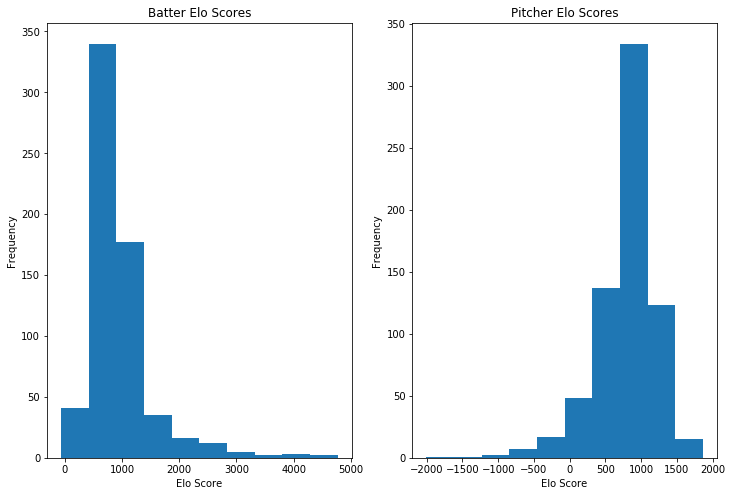

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].hist(batterElos.values())
ax[0].set_xlabel("Elo Score")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Batter Elo Scores")
ax[1].hist(pitcherElos.values())
ax[1].set_xlabel("Elo Score")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Pitcher Elo Scores")

Text(0.5,1,'Pitcher Elo Scores')

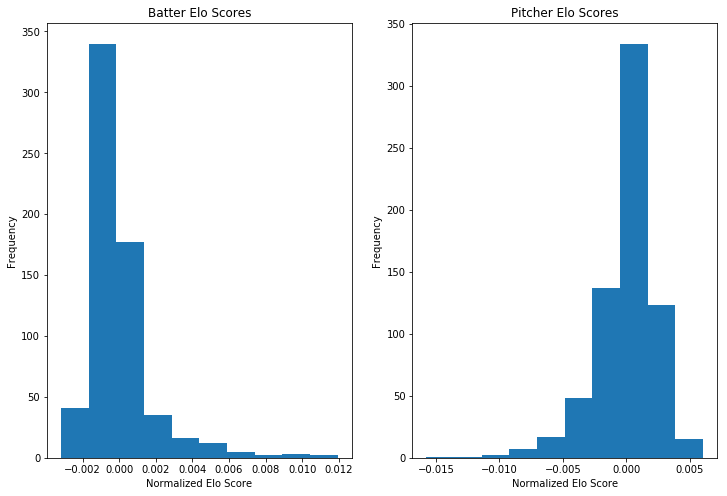

In [50]:
# Scale the data so mean is 0 and variance is 1
bats = list(batterElos.values())
meanBats = np.mean(bats)
varBats = np.var(bats)
newBats = (bats - meanBats) / varBats

pits = list(pitcherElos.values())
meanPits = np.mean(pits)
varPits = np.var(pits)
newPits = (pits - meanPits) / varPits

fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].hist(newBats)
ax[0].set_xlabel("Normalized Elo Score")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Batter Elo Scores")
ax[1].hist(newPits)
ax[1].set_xlabel("Normalized Elo Score")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Pitcher Elo Scores")

Text(0,0.5,'Frequency')

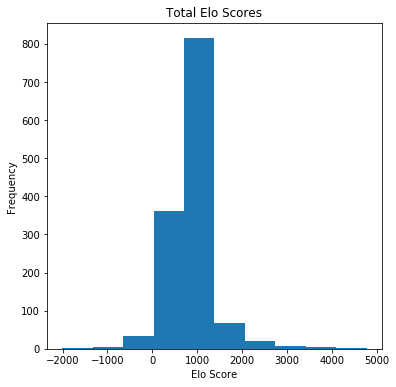

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
total = list(batterElos.values()) + list(pitcherElos.values())
ax.hist(total)
ax.set_title("Total Elo Scores")
ax.set_xlabel("Elo Score")
ax.set_ylabel("Frequency")